In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
META_FILE = 'bpr_meta.tsv'
puzzle_data = pd.read_csv(META_FILE, sep='\t')

In [2]:
#Load the full dataset of puzzle attempts
attempts = pd.read_csv("/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00")

In [3]:
#Replace each 0 in the is_passed field with a -1 for calculating the total won - failed later
attempts['is_passed'] = attempts['is_passed'].replace(0, -1,regex=True)

<h2>Get Average User Success Sample Var in Actual Clusters</h2>

In [4]:
#Filter attempts to include only attempts by players who have played at least 100 games
attempts = attempts.loc[attempts['userGamesPlayed'] >= 1000]

In [5]:
#Join cluster labels to puzzles that were clustered
attempts=pd.merge(attempts,puzzle_data[['tactics_problem_id','cluster','tag','rating','bpr_cluster']],on='tactics_problem_id', how='inner')

In [6]:
#Create the rating bin labels
puzzle_end = attempts['rating'].max()
puzzle_start = attempts['rating'].min()
interval = (puzzle_end-puzzle_start)//20
rating_bins = np.arange(puzzle_start,puzzle_end,interval)

In [7]:
attempts['rating_labels'] = pd.cut(attempts['rating'],rating_bins,labels=range(0,((puzzle_end-puzzle_start)//interval)))

In [8]:
attempts.tail()

,user_tactics_problem_id,user_hash,create_date,date,last_game_date,seconds,is_passed,correct_move_count,rating_change,tactics_problem_id,ratingUser,varianceUser,ratingProblem,varianceProblem,userGamesPlayed,cluster,tag,rating,bpr_cluster,rating_labels
48635756,275283392,ac27feab1da16cfdd021ed91aa0d28d5b27ed36a655bfc...,2013-06-28 20:47:45,2013-06-28,2013-06-28,1,1,2,17,387387,2316,97,1981,21,17646,13,Overloading,1532,9,7
48635757,275287634,c051031f37ac43e1fc931c94e1a079fa58fc804bfddc04...,2013-06-28 21:07:42,2013-06-28,2013-06-28,21,1,2,11,387387,2093,79,1979,21,1725,13,Overloading,1532,9,7
48635758,275294194,4221b560d6a95c5783236b5257ffa517ba10871c9f88f4...,2013-06-28 21:43:07,2013-06-28,2013-06-27,62,1,2,6,387387,2089,86,1973,21,8024,13,Overloading,1532,9,7
48635759,275338250,ab67d05e7822828bc18e20418fd7054b659dd7ea44321b...,2013-06-29 01:06:31,2013-06-29,2013-06-29,40,1,2,11,387387,2034,64,1978,21,7874,13,Overloading,1532,9,7
48635760,275426270,93520d4c5a91227fbf4fd7a1e7d0473033873325140b5f...,2013-06-29 06:11:09,2013-06-29,2012-12-23,31,1,2,4,387387,2046,350,1982,21,2091,13,Overloading,1532,9,7


In [9]:
#Calculate performance rating per cluster per user
import time

def time_command(command,criteria):
    print('Running: ' + command)
    start = time.time()
    exec(command)
    print('Took: '  + str(time.time()-start))

def calc_user_performance(time=False,criteria='cluster'):
    commands = ["global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()",
                "global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()",
                "global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()"]
    for command in commands:
        if time:
            time_command(command,criteria)
        else:
            exec(command)
    return (opponent_ratings_total + 400*wins_plus_losses)/num_cluster_games

In [10]:
#Calculate the accuracy of each player in each cluster
def calc_user_accuracy(time=False,criteria='cluster'):
    commands = ["global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()",
                "global num_wins; num_wins = attempts.loc[attempts.is_passed == 1].groupby(['user_hash',criteria])['tactics_problem_id'].count()"]
    for command in commands:
        if time:
            time_command(command,criteria)
        else:
            exec(command)
    return num_wins/num_cluster_games

In [11]:
#Get variance of performance rating per cluster per user
ratebin_performance_user = calc_user_performance(True,criteria='rating_labels')
avg_ratebin_variance = ratebin_performance_user.var(level=0).agg('mean')
print(avg_ratebin_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 93.87803816795349
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 65.72332262992859
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 49.48749017715454
301684.7407600879


In [12]:
#Get variance of performance rating per cluster per user
cluster_performance_user = calc_user_performance(True)
avg_cluster_variance = cluster_performance_user.var(level=0).agg('mean')
print(avg_cluster_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 52.80535292625427
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 61.5224027633667
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 46.60187864303589
108281.5993984598


In [13]:
#Get variance of performance rating per cluster per user
bpr_performance_user = calc_user_performance(time=True,criteria='bpr_cluster')
avg_bpr_variance = bpr_performance_user.var(level=0).agg('mean')
print(avg_bpr_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 49.9693386554718
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 60.08043146133423
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 45.7137565612793
110985.33692446668


In [14]:
#Get variance of performance rating per tag per user
tag_performance_user = calc_user_performance(time=True,criteria='tag')
avg_tag_variance = tag_performance_user.var(level=0).agg('mean')
print(avg_tag_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 47.67429518699646
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 57.87936449050903
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 46.34751224517822
46236.27020432449


In [18]:
import matplotlib.pyplot as plt


def plot_tag_counts(series,label,filename):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    newdata = series.sort_values(ascending=False)
    newdata = newdata.reset_index()[0]
    ax.bar(newdata.index, newdata.values,align='edge')
    ax.set_xticklabels(newdata.index,rotation='vertical')
    plt.title(label)
    plt.tight_layout()
    #plt.savefig('../plots/presentation/' + filename)
    plt.show()


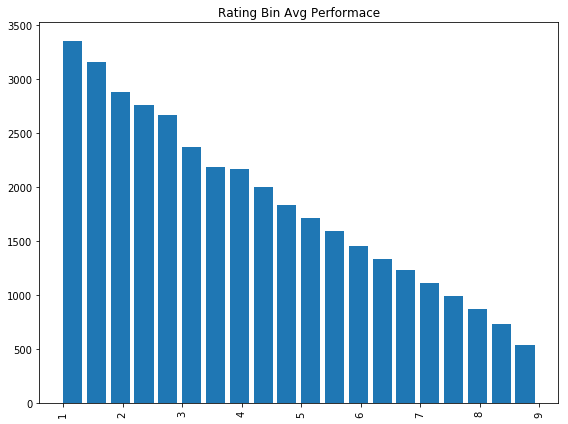

In [19]:
ratebin_avgs = ratebin_performance_user.groupby('rating_labels').agg('mean')
plot_tag_counts(ratebin_avgs,'Rating Bin Avg Performace','ratingbin_avg_performance')

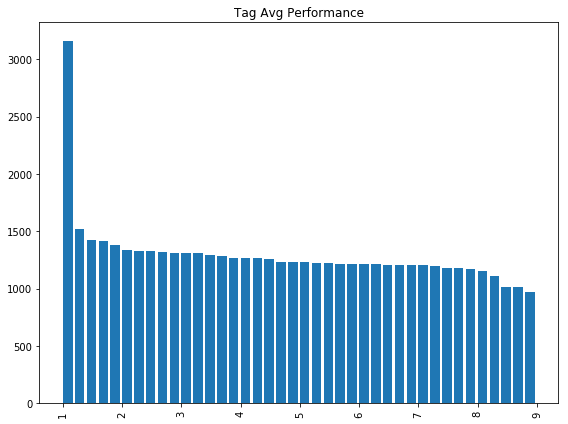

In [20]:
tag_avgs = tag_performance_user.groupby('tag').agg('mean')
plot_tag_counts(tag_avgs,'Tag Avg Performance','tag_avg_performance')

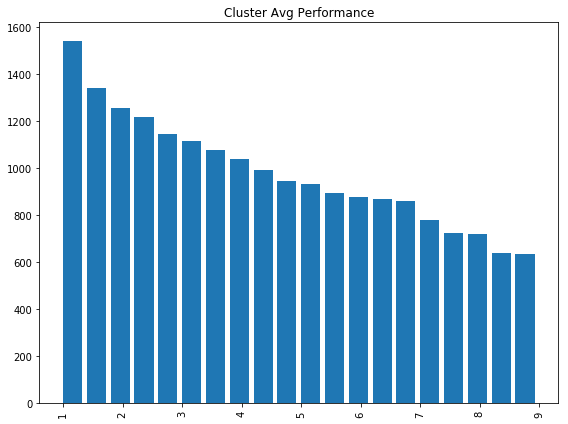

In [21]:
cluster_avgs = cluster_performance_user.groupby('cluster').agg('mean')
#cluster_avgs.index = map(str, range(1,21))
plot_tag_counts(cluster_avgs,'Cluster Avg Performance','cluster_avg_performance')

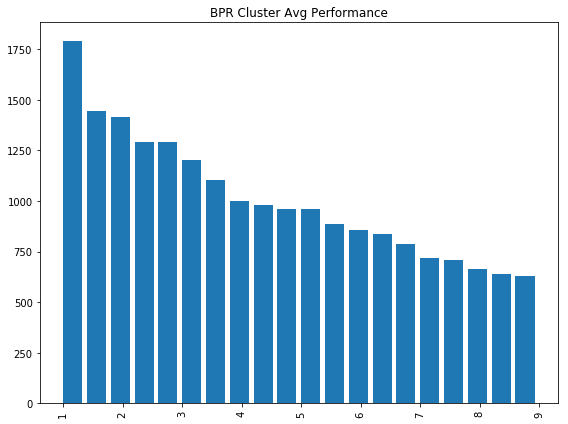

In [22]:
bpr_avgs = bpr_performance_user.groupby('bpr_cluster').agg('mean')
plot_tag_counts(bpr_avgs,'BPR Cluster Avg Performance','bpr_avg_performance')

In [ ]:
print('Ratebin Max and Min Performances')
print(max(ratebin_avgs))
print(min(ratebin_avgs))
print('---------')
print('Tag Max and Min Performances')
print(max(tag_avgs))
print(min(tag_avgs))
print('---------')
print('Cluster Max and Min Performances')
print(max(cluster_avgs))
print(min(cluster_avgs))
print('---------')
print('BPR Max and Min Performances')
print(max(bpr_avgs))
print(min(bpr_avgs))

<h2>Get Average User Success Sample Var in Fake Clusters</h2>

In [23]:
#Get number of puzzles in each cluster and create a numpy array of cluster labels so that the number of labels
#for cluster 'a' correspond to the count of cluster a in the original puzzle metadata
cluster_count = puzzle_data.groupby('cluster')['tactics_problem_id'].nunique().values
cluster_list = np.array([])
for i in range(20):
    clust_labels = np.full(cluster_count[i],i+1)
    cluster_list = np.append(cluster_list,clust_labels)
cluster_list = cluster_list.astype(int)

In [24]:
#Shuffle the order of the rows of the original puzzle metadata
puzzle_data_shuffled = puzzle_data.copy().sample(frac=1).reset_index(drop=True)
#Add the clusters to the shuffled puzzles so that the mismatch will create clusters of equal size as the original
#But with the puzzles grouped randomly
puzzle_data_shuffled['cluster'] = cluster_list
#Shuffle again for appearance
puzzle_data_shuffled = puzzle_data_shuffled.sample(frac=1).reset_index(drop=True)

In [25]:
puzzle_data_shuffled.head()

,tactics_problem_id,puzzle_id,rating,rd,attempt_count,average_seconds,move_count,tags,fen,tag,cluster,bpr_cluster
0,78604,20923,660,42.14,33691,24,1,"Mate in 1,Smothered Mate",https://lichess.org/analysis/r2q2rk/pppbN1pp/3...,Smothered Mate,4,20
1,28720,1447,983,44.69,61091,47,2,Fork / Double Attack,https://lichess.org/analysis/5bk1/ppp2r2/2n1rq...,Fork / Double Attack,9,6
2,187797,39819,400,40.00,5829,13,1,Mate in 1,https://lichess.org/analysis/r4rk1/1pq2p1p/3bp...,Mate in 1,8,5
3,158121,35235,1442,45.32,60953,40,2,"Discovered Attack,Interference,Trapped Piece,X...",https://lichess.org/analysis/r1bq1r1k/pppnn1pp...,X-Ray Attack,5,9
4,194000,40732,400,40.00,4025,10,1,Mate in 1,https://lichess.org/analysis/2k4r/1p6/pR6/P6r/...,Mate in 1,4,4


In [26]:
#Loop that recreates random baseline clusters and recomputes the average variance of player skills in each cluster
results = []
trials = 3
for i in tqdm(range(trials)):
    puzzle_data_shuffled = puzzle_data.copy().sample(frac=1).reset_index(drop=True)
    puzzle_data_shuffled['cluster'] = cluster_list
    attempts.drop(['cluster'],axis=1,inplace=True)
    attempts=pd.merge(attempts,
                      puzzle_data_shuffled[['tactics_problem_id','cluster']],
                      on='tactics_problem_id', 
                      how='inner')
    #Get variance of performance rating per cluster per user
    performance_user = calc_user_performance()
    avg_cluster_variance = performance_user.var(level=0).agg('mean')
    print(avg_cluster_variance)
    results.append(avg_cluster_variance)

38509.211342645125
37234.771844508105
37678.14545240125



In [27]:
print(min(results))
print(sum(results)/3)
print(max(results))

37234.771844508105
37807.37621318483
38509.211342645125


<h2>Add Cluster Performance to Prediction Data</h2>

In [ ]:
pred_data_file = '../prediction_data_diff_rating.csv'
data = pd.read_csv(pred_data_file)

In [ ]:
data.head()

In [ ]:
#Get the cluster performance for each user in both clusters of the prediction data
def get_cluster_performance(row):
    user_scores = cluster_performance_user.loc[row['user_hash']]
    clus1 = user_scores[row['cluster_1']]
    clus2 = user_scores[row['cluster_2']]
    row['cluster_1_perf'] = clus1
    row['cluster_2_perf'] = clus2
    return row

data = data.progress_apply(lambda x: get_cluster_performance(x),axis=1)

In [ ]:
#Save 
data.to_csv(pred_data_file,header=True,index=False)